# **Speech Emotion Recognition**

## **1. Data Preparation**

### Importing Libraries

In [ ]:
!pip install emd
!pip install neurokit2
!pip install Signal_Analysis

In [1]:
# ignore warnings 
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [1]:
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# librosa is a Python library for analyzing audio.
import librosa
import librosa.display

# to play the audio files
from IPython.display import Audio

# to extract features
import emd
from scipy.io.wavfile import read, write
import signal
import scipy.signal
from Signal_Analysis.features import signal 
import neurokit2 as nk

# for ML
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

### Data Preparation

In [2]:
# path for data
from google.colab import drive
drive.mount('/content/gdrive')
data_path='/content/gdrive/My Drive/TheXpert/VAM/data'

Mounted at /content/gdrive


In [3]:
# setting-up the VAM DataFrame by putting each audio path with the associated emotion labels
path = []
labels = ['Valence','Activation','Dominance']

# dataframe for emotion labels of audio files
emotion_labels_df = pd.DataFrame(columns=labels)

data_directory_list = os.listdir(data_path)
data_directory_list.sort()
for dir in data_directory_list:
  # as their are 47 different "sprechers" in our previous directory we need to extract files for each sprecher.
    sprecher = os.listdir(data_path + '/' + dir)
    sprecher.sort()
    for file in sprecher:
      file_extension = file[9:13]
      file_path = data_path + '/' + dir +'/' +file
      if file_extension == '.wav' : 
        # this file is an audio
        path.append(file_path)
      elif file_extension == '.ewe' :
        # this file contains the emotion labels of an audio
        labels_vector = pd.read_csv(file_path, sep=" ", header=None).dropna(axis=1)
        labels_vector.set_axis(labels,axis=1,inplace=True)
        emotion_labels_df = emotion_labels_df.append(labels_vector, ignore_index=True)
      else :
        pass
        
# dataframe for path of audio files
path_df = pd.DataFrame(path, columns=['Path'])

# the final VAM DataFrame
VAM_df = pd.concat([emotion_labels_df, path_df], axis=1, ignore_index=False)

In [ ]:
VAM_df.head()

In [12]:
activation_df=VAM_df[['Activation']]
activation_df.describe()

,Activation
count,947.000000
mean,0.027956
std,0.342720
min,-0.832441
25%,-0.231562
50%,-0.056903
75%,0.235557
max,1.000000


## **2. Feature Extraction**

### **Features**

**Zero-Crossing Rate**

In [ ]:
def zcr(audio_time_series):
  '''returns a DataFrame of ZCR feature of an audio'''
  zcr=list(np.mean(librosa.feature.zero_crossing_rate(audio_time_series).T, axis=0))
  zcr_df = pd.DataFrame(zcr, columns=['ZCR'])
  return zcr_df

**MFCC**

In [ ]:
def mfcc(audio_time_series, sampling_rate):
  '''returns a DataFrame of MFCC features of an audio'''
  mfcc=list(np.mean(librosa.feature.mfcc(audio_time_series, sampling_rate,  n_mfcc=13).T, axis=0))
  mfcc_df = pd.DataFrame(columns=['MFCC%i' % i for i in range(1,14)])
  mfcc_series = pd.Series(mfcc, index = mfcc_df.columns)
  mfcc_df = mfcc_df.append(mfcc_series, ignore_index=True)
  return mfcc_df

**Root Mean Square Energy**

In [ ]:
def rmse(audio_time_series):
  '''returns a DataFrame of RMS feature of an audio'''
  rmse=list(np.mean(librosa.feature.rms(audio_time_series).T, axis=0))
  rmse_df = pd.DataFrame(rmse, columns=['RMSE'])
  return rmse_df

**Energy**

In [ ]:
def energy(audio_time_series):
  '''returns a DataFrame of Energy feature of an audio'''
  energy = [np.mean(np.array([sum(abs(audio_time_series[i:i+1]**2)) for i in range(0, len(audio_time_series))]))]
  energy_df = pd.DataFrame(energy, columns=['Energy'])
  return energy_df

**ECC**

In [ ]:
# necessary functions for the calculation of ecc

def emg_amplitude(emg_cleaned):
  '''returns the amplitude'''
  tkeo = emg_amplitude_tkeo(emg_cleaned)
  amplitude = emg_amplitude_envelope(tkeo)
  return amplitude


def emg_amplitude_tkeo(emg_cleaned):
  '''returns the Taeger-Kaiser Energy Operator'''
  tkeo = emg_cleaned.copy()
  # Teager–Kaiser Energy operator
  tkeo[1:-1] = emg_cleaned[1:-1] * emg_cleaned[1:-1] - emg_cleaned[:-2] * emg_cleaned[2:]
  # correct the data in the extremities
  tkeo[0], tkeo[-1] = tkeo[1], tkeo[-2]
  return tkeo


def emg_amplitude_envelope(emg_cleaned, sampling_rate=1000, lowcut=10, highcut=400, envelope_filter=8):
  '''returns the linear envelope'''
  filtered = nk.signal_filter(
      emg_cleaned, sampling_rate=sampling_rate, lowcut=lowcut, highcut=highcut, method="butterworth", order=2
  )
  envelope = np.abs(filtered)
  envelope = nk.signal_filter(
      envelope, sampling_rate=sampling_rate, lowcut=None, highcut=envelope_filter, method="butterworth", order=2
  )
  return envelope

In [ ]:
def ecc(audio_time_series, sampling_rate):
  '''returns a DataFrame of ECC feature of an audio'''
  IP, IF, IA = emd.spectra.frequency_transform(audio_time_series, sampling_rate, 'hilbert')
  freq_range = (0.1, 10, 80, 'log')
  f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)
  imf = emd.sift.sift(audio_time_series)
  m=len(imf.T)
  ecc=0
  for f in range (1,m):
      for i in range (180):
          ecc=ecc+emg_amplitude(imf.T[f])[i]**2
  ecc_df = pd.DataFrame([ecc/m], columns=['ECC'])
  return ecc_df

**Pitch**

In [ ]:
def pitch(audio_time_series, sampling_rate):
  '''returns a DataFrame of Pitch feature of an audio'''
  fmin=10.0
  fmax=2000.0
  # compute autocorrelation of input segment
  autocorrelation = librosa.autocorrelate(audio_time_series)
      
  # define lower and upper limits for the autocorrelation argmax.
  i_min = sampling_rate/fmax
  i_max = sampling_rate/fmin
  autocorrelation[:int(i_min)] = 0
  autocorrelation[int(i_max):] = 0

  # find the location of the maximum autocorrelation.
  i = autocorrelation.argmax()
  f0 = [float(sampling_rate)/i]

  pitch_df = pd.DataFrame(f0, columns=['Pitch'])
  return pitch_df

**Jitter**

In [ ]:
def jitter(audio_time_series, sampling_rate):
  '''returns a DataFrame of Jitter feature of an audio'''
  jitter=list(signal.get_Jitter(audio_time_series, sampling_rate).values())
  jitter_df = pd.DataFrame(columns=['jitter_ddp','jitter_local','jitter_localAbs','jitter_ppq5','jitter_rap'])
  jitter_series = pd.Series(jitter, index = jitter_df.columns)
  jitter_df = jitter_df.append(jitter_series, ignore_index=True)
  return jitter_df

### **Feature Extraction**

In [ ]:
def extract_features(audio_path):
  '''returns a DataFrame of all features of an audio'''
  audio_time_series, sampling_rate = librosa.load(audio_path)
  # ZCR
  zcr_df = zcr(audio_time_series)
  # MFCC
  mfcc_df = mfcc(audio_time_series, sampling_rate)
  # RMSE
  rmse_df = rmse(audio_time_series)
  # Energy
  energy_df = energy(audio_time_series)
  # ECC
  ecc_df = ecc(audio_time_series, sampling_rate)
  # Pitch
  pitch_df = pitch(audio_time_series, sampling_rate)
  # Jitter
  jitter_df = jitter(audio_time_series, sampling_rate)
  # All features in one df
  features_df = pd.concat([zcr_df, mfcc_df, rmse_df, energy_df, ecc_df, pitch_df, jitter_df], axis = 1)
  return features_df

In [ ]:
def VAM_features_extraction():
  '''extracts features from The whole VAM database'''
  VAM_features_df = pd.DataFrame()
  for audio_path in VAM_df.Path :
    features_df = extract_features(audio_path)
    VAM_features_df = VAM_features_df.append(features_df, ignore_index=True)
  return VAM_features_df

In [ ]:
%%capture
# VAM_features_df = VAM_features_extraction()
# VAM_features_df.head()

In [ ]:
# We save the VAM features dataframe in a csv file to avoid redoing the execution from the beginning each time.
# VAM_features_df.to_csv("features.csv", index=False)

In [4]:
VAM_features_df = pd.read_csv('/content/gdrive/My Drive/TheXpert/features.csv')

In [ ]:
VAM_features_df.head()

,ZCR,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,MFCC9,...,MFCC13,RMSE,Energy,ECC,Pitch,jitter_ddp,jitter_local,jitter_localAbs,jitter_ppq5,jitter_rap
0,0.089336,-341.61487,120.276300,-42.477470,30.991186,-39.109978,15.143028,-32.043160,-0.525213,-20.776123,...,0.892459,0.032530,0.001510,-0.095646,229.687500,0.055228,0.000245,0.028022,0.030926,0.084065
1,0.123556,-216.21648,116.735240,-74.047280,23.661655,-59.753185,21.422775,-30.230928,6.099126,-23.295979,...,-4.593135,0.066239,0.005625,-0.094320,350.000000,0.066329,0.000203,0.034297,0.036561,0.102891
2,0.066625,-277.31638,106.002420,-60.257313,36.139027,-44.240696,-4.502086,-40.700210,-1.614276,-23.133070,...,0.359459,0.062893,0.004654,-0.013776,148.986486,0.058888,0.000193,0.029849,0.034419,0.089546
3,0.153096,-283.74430,82.799385,-53.151123,39.829483,-43.906757,6.502102,-32.495953,-0.842892,-15.286530,...,2.571858,0.046380,0.003191,-0.095646,355.645161,0.063864,0.000203,0.034605,0.034521,0.103816
4,0.102195,-369.72543,108.694570,-41.308640,40.764250,-42.790752,14.047110,-31.884580,2.032239,-16.350502,...,5.400357,0.018916,0.000519,-0.088207,242.307692,0.044167,0.000181,0.024578,0.025494,0.073733


# Data Balencing and resampling

Data Balancing

In [5]:
resample_df=pd.concat([emotion_labels_df, VAM_features_df], axis = 1)
resample_df.head()

,Valence,Activation,Dominance,ZCR,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,...,MFCC13,RMSE,Energy,ECC,Pitch,jitter_ddp,jitter_local,jitter_localAbs,jitter_ppq5,jitter_rap
0,-0.477663,-0.025782,-0.098200,0.089336,-341.61487,120.276300,-42.477470,30.991186,-39.109978,15.143028,...,0.892459,0.032530,0.001510,-0.095646,229.687500,0.055228,0.000245,0.028022,0.030926,0.084065
1,-0.618995,0.736195,0.613617,0.123556,-216.21648,116.735240,-74.047280,23.661655,-59.753185,21.422775,...,-4.593135,0.066239,0.005625,-0.094320,350.000000,0.066329,0.000203,0.034297,0.036561,0.102891
2,-0.062291,0.174681,0.080033,0.066625,-277.31638,106.002420,-60.257313,36.139027,-44.240696,-4.502086,...,0.359459,0.062893,0.004654,-0.013776,148.986486,0.058888,0.000193,0.029849,0.034419,0.089546
3,-0.586049,0.409463,0.376323,0.153096,-283.74430,82.799385,-53.151123,39.829483,-43.906757,6.502102,...,2.571858,0.046380,0.003191,-0.095646,355.645161,0.063864,0.000203,0.034605,0.034521,0.103816
4,-0.200191,-0.441815,-0.272061,0.102195,-369.72543,108.694570,-41.308640,40.764250,-42.790752,14.047110,...,5.400357,0.018916,0.000519,-0.088207,242.307692,0.044167,0.000181,0.024578,0.025494,0.073733


In [8]:
#Shape of each category
df_1=resample_df[resample_df['Valence']>0]
df_2=resample_df[resample_df['Valence']<0]
print(len(df_1))
print(len(df_2))

71
875


Resampling

In [10]:
df_1_upsample=resample(df_1,replace=True,n_samples=400,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=400,random_state=124)
VAM_features_df_sampled=pd.concat([df_1_upsample,df_2_upsample])
emotion_labels_df_sampled=VAM_features_df_sampled[VAM_features_df_sampled.columns[0:3]]
VAM_features_df_sampled=VAM_features_df_sampled[VAM_features_df_sampled.columns[3:26]]

## **3. Feature Selection using PCA**

### Selecting the optimal number of PCA components

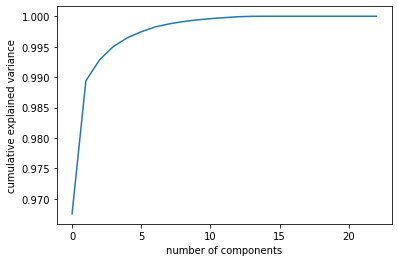

In [ ]:
pca = PCA()
features_pca = pca.fit_transform(VAM_features_df_sampled)
explained_variance = pca.explained_variance_ratio_
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

According to the figure below we notice that n_components=5 will allow to keep nearly 99.8% of the variance

### Computing the first 5 principal components

In [ ]:
pca = PCA(n_components=5)
features_transformed = StandardScaler().fit_transform(VAM_features_df_sampled)
pca_df = pca.fit_transform(features_transformed)
pca_df = pd.DataFrame(pca_df, columns=['PC%i' % i for i in range(1,6)])

In [ ]:
pca_df.head()

## **4. Modeling and Evaluation** 

### Splitting the dataset into training and testing sets

In [ ]:
# concatenate labels with the corresponding principal components
emotion_labels_df_sampled = emotion_labels_df_sampled.reset_index(drop=True)
pca_df = pca_df.reset_index(drop=True)
full_df=pd.concat([emotion_labels_df_sampled, pca_df], axis = 1)
full_df.head()

In [ ]:
len(full_df)

In [ ]:
# splitting the dataset into training and testing sets
training_data, testing_data = train_test_split(full_df, test_size=0.2, random_state=25)
print(f"No. of training examples: {training_data.shape[0]}")
print(f"No. of testing examples: {testing_data.shape[0]}")

No. of training examples: 640
No. of testing examples: 160


In [ ]:
# separate labels from principal components

# training set
DataApp=training_data[['PC%i' % i for i in range(1,6)]]
LabelApp=training_data[['Valence','Activation','Dominance']]

# testing set
DataTest=testing_data[['PC%i' % i for i in range(1,6)]]
LabelTest=testing_data[['Valence','Activation','Dominance']]

### **SVR**

**Model**

In [ ]:
#create the pipeline
pipe_svr = Pipeline([('scl', StandardScaler()),
        ('reg', MultiOutputRegressor(SVR()))])

#set parameteres
grid_param_svr = {'reg__estimator__C': [0.1,1,10]}

#Application du gridsearch
gs_svr = (GridSearchCV(estimator=pipe_svr, 
                      param_grid=grid_param_svr, 
                      cv=5,
                      scoring = 'neg_mean_squared_error',
                      n_jobs = -1))

gs_svr = gs_svr.fit(DataApp, LabelApp)

# generate predictions for testing data
LabelPred = gs_svr.predict(DataTest)

In [ ]:
"""svr_gsc = GridSearchCV(
    estimator = SVR(),
    param_grid = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
                        'C' : [1,5,10],
                        'degree' : [3,8],
                        'coef0' : [0.01,10,0.5],
                        'gamma' : ('auto','scale')},
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    cv = 2,
    verbose=False
)"""

In [ ]:
"""svr_gsc_result = MultiOutputRegressor(svr_gsc).fit(DataApp, LabelApp)
svr_gsc_result.estimators_[0].best_estimator_"""

In [ ]:
"""# train the best xgb estimator
best_svr = MultiOutputRegressor(SVR("...")
best_svr.fit(DataApp, LabelApp)"""

**Evaluation**

In [ ]:
SVR_MSE = mean_squared_error(LabelTest.values.tolist(), LabelPred.tolist())
print('The MSE of SVR Regressor is :', round(SVR_MSE, 3))
SVR_MSE_for_each_label = mean_squared_error(LabelTest.values.tolist(), LabelPred.tolist(), multioutput='raw_values')
print('The MSE of SVR Regressor for each label is :', SVR_MSE_for_each_label.round(3))

SVR_MAE = mean_absolute_error(LabelTest.values.tolist(), LabelPred.tolist())
print('The MAE of SVR Regressor is :', round(SVR_MAE, 3))
SVR_MAE_for_each_label = mean_absolute_error(LabelTest.values.tolist(), LabelPred.tolist(), multioutput='raw_values')
print('The MAE of SVR Regressor for each label is :', SVR_MAE_for_each_label.round(3))

The MSE of SVR Regressor is : 0.027
The MSE of SVR Regressor for each label is : [0.038 0.022 0.02 ]
The MAE of SVR Regressor is : 0.122
The MAE of SVR Regressor for each label is : [0.146 0.117 0.105]


### **Random Forest Regressor**

**Model**

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', "log2"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 1, stop = 30, num=30)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Create the Random Forest Regressor
rf = RandomForestRegressor()

# Create the Multioutput Regressor
rf_mor = MultiOutputRegressor(estimator=rf)

rf_random = RandomizedSearchCV(estimator = rf_mor, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Train the regressor
rf_random.fit(DataApp, LabelApp)

best_random = rf_random.best_estimator_

LabelPred = best_random.predict(DataTest)

#Calculate the Training Score 
score=rf_mor.score(DataTest, LabelTest)
print('Trainig score is :', score)

**Evaluation**

In [ ]:
RF_MSE = mean_squared_error(LabelTest.values.tolist(), LabelPred.tolist())
print('The MSE of Random Forest Regressor is :', round(RF_MSE, 3))
RF_MSE_for_each_label = mean_squared_error(LabelTest.values.tolist(), LabelPred.tolist(), multioutput='raw_values')
print('The MSE of Random Forest Regressor for each label is :', RF_MSE_for_each_label.round(3))
print('')
RF_MAE = mean_absolute_error(LabelTest.values.tolist(), LabelPred.tolist())
print('The MAE of Random Forest Regressor is :', round(RF_MAE, 3))
RF_MAE_for_each_label = mean_absolute_error(LabelTest.values.tolist(), LabelPred.tolist(), multioutput='raw_values')
print('The MAE of Random Forest Regressor for each label is :', RF_MAE_for_each_label.round(3))


In [ ]:
# ploting the predected.vs expected result of the DataTest for Valence, Activation and Dominance respectively
x_ax = range(len(DataTest))

plt.plot(x_ax, LabelTest.iloc[:,0:1], label="Valence-test", color='c')
plt.plot(x_ax, LabelPred[:,0:1], label="Valence-pred", color='b')
plt.legend()
plt.show()

plt.plot(x_ax, LabelTest.iloc[:,1:2], label="Activation-test", color='m')
plt.plot(x_ax, LabelPred[:,1:2], label="Activation-pred", color='r')
plt.legend()
plt.show()

plt.plot(x_ax, LabelTest.iloc[:,2:3], label="Dominance-test", color='y')
plt.plot(x_ax, LabelPred[:,2:3], label="Dominance-pred", color='g')
plt.legend()
plt.show()

### **XGBoost Regressor**

**Model**

In [ ]:
xgb_gsc = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror'),
    param_grid={'max_depth': range (10, 70, 5),
    'n_estimators': range(100, 700, 50),
    'learning_rate': [0.1, 0.01, 0.05]},
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1,
    cv = 2,
    verbose=False
)

In [ ]:
gsc_result = MultiOutputRegressor(xgb_gsc).fit(DataApp, LabelApp)
gsc_result.estimators_[0].best_estimator_

In [ ]:
# train the best xgb estimator
best_xgb = MultiOutputRegressor(xgb.XGBRegressor(learning_rate=0.01, max_depth=20, n_estimators=600,
             objective='reg:squarederror', seed = 123))
training = best_xgb.fit(DataApp, LabelApp)

In [ ]:
# make predictions for testing data with the best xgb estimator
LabelPred = best_xgb.predict(DataTest)

**Evaluation**

In [ ]:
# Evaluate XGBoost Regressor with the MAE mesure
xgb_mse = mean_squared_error(LabelTest.values.tolist(), LabelPred.tolist())
print('The MSE of XGBoost Regressor is :', round(xgb_mse, 3))
xgb_mse_for_each_label = mean_squared_error(LabelTest.values.tolist(), LabelPred.tolist(), multioutput='raw_values')
print('The MSE of XGBoost Regressor for each label is :', xgb_mse_for_each_label.round(3))

xgb_mae = mean_absolute_error(LabelTest.values.tolist(), LabelPred.tolist())
print('The MAE of XGBoost Regressor is :', round(xgb_mae, 3))
xgb_mae_for_each_label = mean_absolute_error(LabelTest.values.tolist(), LabelPred.tolist(), multioutput='raw_values')
print('The MAE of XGBoost Regressor for each label is :', xgb_mae_for_each_label.round(3))

The MSE of XGBoost Regressor is : 0.019
The MSE of XGBoost Regressor for each label is : [0.017 0.021 0.017]
The MAE of XGBoost Regressor is : 0.069
The MAE of XGBoost Regressor for each label is : [0.068 0.071 0.068]


## **5. Validation**

In [ ]:
def estimate_emotion(estimator, audio_path):
  # extact features from audio file
  audio_features_df = extract_features(audio_path)
  # PCA 
  audio_pca_df = pca.transform(audio_features_df)
  # prediction
  emotion = estimator.predict(audio_pca_df)
  return emotion

In [ ]:
# read the audio file
Audio('/content/gdrive/My Drive/TheXpert/test.wav')

In [ ]:
%%capture
emotion = estimate_emotion(gs_svr, '/content/gdrive/My Drive/TheXpert/test.wav')
emotion_df = pd.DataFrame(emotion, columns=['Valence', 'Activation', 'Dominance'])

In [ ]:
emotion_df

,Valence,Activation,Dominance
0,-0.107492,0.033133,0.057032


## Interpretation

**Classification de l'Activation par Kmeans**

In [ ]:
from sklearn.cluster import KMeans

kmeans_Activation = KMeans(n_clusters=5)

Label_Activation = pd.DataFrame(LabelApp.Activation)

kmeans_Activation.fit(Label_Activation)

centers = kmeans_Activation.cluster_centers_
centers=centers.tolist()
centers.sort()

centers =pd.DataFrame(centers, columns=['Center'])
classe = pd.DataFrame(["Very low intesity","Low intensity","Neutral","High intensity", "Very high intesity"], columns=['Class'])

Activation = pd.concat([centers, classe],axis =1)

Activation

,Center,Class
0,-0.411456,Very low intesity
1,-0.189518,Low intensity
2,-0.022677,Neutral
3,0.273325,High intensity
4,0.688135,Very high intesity


**Classification de la Dominance par Kmeans**

In [ ]:
kmeans_Dominance = KMeans(n_clusters=3)

Label_Dominance = pd.DataFrame(LabelApp.Dominance)

kmeans_Dominance.fit(Label_Dominance)

centers = kmeans_Dominance.cluster_centers_
centers=centers.tolist()
centers.sort()

centers =pd.DataFrame(centers, columns=['Center'])
classe = pd.DataFrame(["is controled by the situation","is neutral towards the siuation","controls the situation"], columns=['Class'])

Dominance = pd.concat([centers, classe],axis =1)

Dominance

,Center,Class
0,-0.165477,is controled by the situation
1,0.101138,is neutral towards the siuation
2,0.539091,controls the situation


**Fonction d'interpretation**

In [ ]:
def Interpret_Result(primitive):
  v=''
  primitive=pd.DataFrame(primitive)

  valence = float(np.array(primitive.iloc[:,0:1]))
  if(valence>=0):
    v="a pleasant emotion "
  else :
    v="an unpleasant emotion "

  activation = pd.DataFrame(primitive.Activation)
  act_kmeans = kmeans_Activation.predict(activation.iloc[0:1,:])
  act= Activation.Class[int(act_kmeans)]

  dominance = pd.DataFrame(primitive.Dominance)
  dom_kmeans = kmeans_Dominance.predict(dominance.iloc[0:1,:])
  dom=Dominance.Class[int(dom_kmeans)]

  print('This condidate presents ',v,'with ',act,' and he/she ',dom)

**Test**

In [ ]:
# Interprétation de l'audio test
prim=pd.DataFrame(emotion_df)
print(prim)
print(Interpret_Result(prim))

    Valence  Activation  Dominance
0 -0.107492    0.033133   0.057032
This condidate presents  an unpleasant emotion  with  Very high intesity  and he/she  is controled by the situation
None
